# Preparing data for modeling


In [1]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import scipy as sp
import pickle

In [2]:
DATASET = 'data/4_final_dataset/final_dataset.csv'
ISW_DATA = 'data/4_final_dataset/isw_final.csv'

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df = pd.read_csv(DATASET, sep=';')
df.head(10)

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_solarradiation,day_solarenergy,day_uvindex,day_sunrise,day_sunset,day_moonphase,hour_datetime,hour_datetimeEpoch,hour_temp,hour_humidity,hour_dew,hour_precip,hour_precipprob,hour_snow,hour_snowdepth,hour_preciptype,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,city,region,center_city_ua,center_city_en,region_alt,region_id,event_region_title,event_region_city,event_all_region,event_start,event_end,event_clean_end,event_intersection_alarm_id,event_start_time,event_end_time,event_start_hour,event_end_hour,event_day_date,event_start_hour_datetimeEpoch,event_end_hour_datetimeEpoch,event_hour_level_event_time,event_hour_level_event_datetimeEpoch,is_alarm,alarms_countrywide,datetime,n_alarms_last24hrs,is_weekend,region_of_Ukraine
0,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,00:00:00,1645653600,2.4,89.18,0.8,0.000,0.0,0.1,0.2,['snow'],31.3,15.5,275.6,1020.0,0.0,91.5,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,2022-02-24 00:00:00,0,False,west
1,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,01:00:00,1645657200,2.4,87.90,0.6,0.000,0.0,0.0,0.2,['snow'],27.7,14.8,280.3,1021.0,0.2,88.2,0.0,NaN,0.0,10.0,Partially cloudy,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,2022-02-24 01:00:00,0,False,west
2,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,02:00:00,1645660800,2.9,88.58,1.2,0.000,0.0,0.0,0.1,['snow'],29.2,14.4,310.0,1022.0,10.0,100.0,NaN,NaN,NaN,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,2022-02-24 02:00:00,0,False,west
3,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,03:00:00,1645664400,2.3,86.63,0.3,0.000,0.0,0.0,0.1,['snow'],23.8,13.3,295.1,1021.0,0.1,92.0,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,2022-02-24 03:00:00,0,False,west
4,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,04:00:00,1645668000,1.9,87.85,0.1,0.000,0.0,0.0,0.1,['snow'],24.5,13.3,305.8,1021.0,0.0,93.8,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,2022-02-24 04:00:00,0,False,west
5,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,05:00:00,1645671600,1.9,91.66,0.6,0.000,0.0,0.0,0.1,NaN,23.4,10.8,296.0,1022.5,10.0,100.0,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,2022-02-24 05:00:00,0,False,west
6,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,06:00:00,1645675200,2.0,93.09,1.0,0.000,0.0,0.0,0.1,['snow'],20.9,10.8,300.0,1021.0,10.0,100.0,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,2022-02-24 06:00:00,0,False,west
7,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,07:00:00,1645678800,2.0,93.09,1.0,0.000,0.0,0.0,0.1,['snow'],19.1,10.8,300.0,1022.0,10.0,100.0,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3,NaN,NaN,NaN,NaN,NaN

## ISW Data Prep

In [5]:
df_isw = pd.read_csv(ISW_DATA)

In [6]:
df_isw = df_isw.drop(columns={
    'report_date',
    'title',
    'text_title',
    'main_text',
    'text_stemm',
    'keywords'
})

In [7]:
df_isw.head(2)

,text_lemm,following_date
0,russian president vladimir putin began large ...,2022-02-25
1,mason clark george barros kateryna stepanenko...,2022-02-26


In [8]:
df_merged = pd.merge(df, 
                     df_isw, 
                     left_on='day_datetime', 
                     right_on='following_date')

In [9]:
df_merged = df_merged.sort_values('datetime', ignore_index=True)

In [21]:
exclude = {
    'city_resolvedAddress',
    'day_datetimeEpoch',
    'datetime',
    'day_datetime',
    'hour_datetime',
    'hour_datetimeEpoch',
    'day_sunrise',
    'day_sunset',
    'hour_preciptype',
    'hour_conditions',
    'hour_solarenergy',
    'city',
    'center_city_ua',
    'center_city_en',
    'region_alt',
    'event_region_title',
    'event_region_city',
    'event_all_region',
    'event_start',
    'event_end',
    'event_clean_end',
    'event_intersection_alarm_id',
    'event_start_time',
    'event_end_time',
    'event_start_hour',
    'event_end_hour',
    'event_day_date',
    'event_start_hour_datetimeEpoch',
    'event_end_hour_datetimeEpoch',
    'event_hour_level_event_time',
    'event_hour_level_event_datetimeEpoch',
    'region',
    'region_of_Ukraine',
    'following_date'
}

In [19]:
df_merged = df_merged.drop(columns=exclude)

In [12]:
df_merged.head(10)

,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_solarradiation,day_solarenergy,day_uvindex,day_moonphase,hour_temp,hour_humidity,hour_dew,hour_precip,hour_precipprob,hour_snow,hour_snowdepth,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,region_id,is_alarm,alarms_countrywide,n_alarms_last24hrs,is_weekend,text_lemm
0,6.3,-0.3,2.2,-1.2,78.3,0.20,8.33,45.7,3.3,2.0,0.8,0.3,82.68,-2.3,0.0,0.0,0.0,0.0,25.6,14.4,171.2,1019.0,24.1,100.0,0.0,NaN,0.0,10.0,3,False,0,0,False,russian president vladimir putin began large ...
1,7.2,-2.3,1.7,-1.5,81.0,0.10,4.17,90.3,7.9,3.0,0.8,-0.7,88.26,-2.4,0.0,0.0,0.0,0.1,21.2,12.6,166.4,1021.0,24.1,0.0,0.0,NaN,0.0,10.0,19,False,0,0,False,russian president vladimir putin began large ...
2,5.2,-2.2,1.2,-2.6,76.6,0.00,0.00,150.6,13.5,4.0,0.8,-0.2,89.61,-1.7,0.0,0.0,0.0,0.0,8.6,5.0,95.8,1024.0,24.1,15.2,0.0,NaN,0.0,10.0,23,False,0,0,False,russian president vladimir putin began large ...
3,7.3,-1.1,3.1,-1.3,74.8,0.10,4.17,116.4,10.3,3.0,0.8,0.5,85.81,-1.6,0.0,0.0,0.0,0.0,10.8,6.5,171.8,1023.0,24.1,0.0,0.0,NaN,0.0,10.0,6,False,0,0,False,russian president vladimir putin began large ...
4,7.4,-0.1,2.0,-0.1,86.3,0.80,4.17,36.0,3.3,2.0,0.8,2.1,87.87,0.3,0.0,0.0,0.0,0.0,19.4,7.9,55.4,1023.0,24.1,100.0,0.0,NaN,0.0,10.0,4,False,0,0,False,russian president vladimir putin began large ...
5,6.9,-0.6,2.4,-0.9,80.0,0.01,4.17,81.4,5.9,3.0,0.8,0.3,83.91,-2.1,0.0,0.0,0.0,0.0,19.4,11.5,163.6,1020.0,24.1,0.0,0.0,NaN,0.0,10.0,17,False,0,0,False,russian president vladimir putin began large ...
6,7.4,1.8,4.0,1.6,84.8,0.80,4.17,70.3,6.2,3.0,0.8,2.5,82.96,-0.1,0.0,0.0,0.0,0.0,22.0,11.9,34.5,1022.0,24.1,100.0,0.0,NaN,0.0,10.0,8,False,0,0,False,russian president vladimir putin began large ...
7,6.0,-1.0,2.6,-0.4,81.9,0.00,0.00,126.2,11.1,4.0,0.8,2.0,100.00,2.0,0.0,0.0,0.0,0.0,8.6,7.2,150.0,1022.0,6.0,100.0,0.0,NaN,0.0,10.0,10,False,0,0,False,russian president vladimir putin began large ...
8,5.7,-1.3,1.8,-1.9,76.7,0.00,0.00,110.8,8.0,3.0,0.8,0.4,78.46,-2.9,0.0,0.0,0.0,0.0,17.3,8.9,33.0,1021.6,20.0,40.0,0.0,NaN,0.0,10.0,7,False,0,0,False,russian president vladimir putin began large ...
9,7.5,1.6,4.2,2.1,86.8,3.50,25.00,99.4,8.7,4.0,0.8,1.8,90.42,0.4,0.6,100.0,0.0,0.0,27.7,13.3,48.7,1022.0,24.1,100.0,0.0,NaN,0.0,10.0,5,False,0,0,False,russian president vladimir putin began large ...


In [17]:
y = df_merged['is_alarm']
df_merged = df_merged.drop(columns={'is_alarm'})
df_merged = df_merged.fillna(method='ffill')

In [20]:
nans_per_column = df_merged.isna().sum(axis=0)
nans_per_column

day_tempmax            0
day_tempmin            0
day_temp               0
day_dew                0
day_humidity           0
day_precip             0
day_precipcover        0
day_solarradiation     0
day_solarenergy        0
day_uvindex            0
day_moonphase          0
hour_temp              0
hour_humidity          0
hour_dew               0
hour_precip            0
hour_precipprob        0
hour_snow              0
hour_snowdepth         0
hour_windgust          0
hour_windspeed         0
hour_winddir           0
hour_pressure          0
hour_visibility        0
hour_cloudcover        0
hour_solarradiation    0
hour_uvindex           0
hour_severerisk        0
region_id              0
alarms_countrywide     0
n_alarms_last24hrs     0
is_weekend             0
text_lemm              0
dtype: int64

In [22]:
df_merged.shape

(210979, 32)

## Chunking the Data & Concatenating TF-IDF Vectors to the Final Dataset

In [23]:
tfidf = pickle.load(open('data/3_isw_vectorized_data/tfidf_transformer.pkl', 'rb'))
cv = pickle.load(open('data/3_isw_vectorized_data/cv.pkl', 'rb'))

In [24]:
chunks = np.array_split(df_merged, 100)

In [25]:
X = sp.sparse.csr_matrix((0, 9222), dtype=float)

for chunk in chunks:
    cv_vector = cv.transform(chunk['text_lemm'].values.astype('U'))
    tfidf_vec = tfidf.transform(cv_vector)
    chunk = chunk.drop(columns={'text_lemm'})
    chunk_csr = sp.sparse.csr_matrix(chunk.values.astype(float))
    chunk_merged = sp.sparse.hstack((chunk_csr, tfidf_vec), format='csr')
    X = sp.sparse.vstack((X, chunk_merged))

In [26]:
X.shape

(210979, 9222)

## Separating Data  
#### using `sklearn.model_selection.TimeSeriesSplit`

In [27]:
tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

In [28]:
X_train.shape

(175816, 9222)

In [29]:
X_test.shape

(35163, 9222)

# Training Models

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

### Model 1 | Logistic Regression

In [58]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

KeyboardInterrupt: 

### Model 2 | Support Vector Machines

In [ ]:
lsvc = LinearSVC(max_iter=10000)
lsvc.fit(X_train, y_train)

### Model 3 | Stochastic Gradient Descent

### Model 4 | Forests of randomized trees

### Model 5 | ...

### Model 6 | ...

# Model Evaluation

In [38]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

### Model 1 

### Model 2 

In [59]:
y_predicted_lsvc = lsvc.predict(X_test)
np.mean(y_predicted_lsvc == y_test)

0.9304951227142166

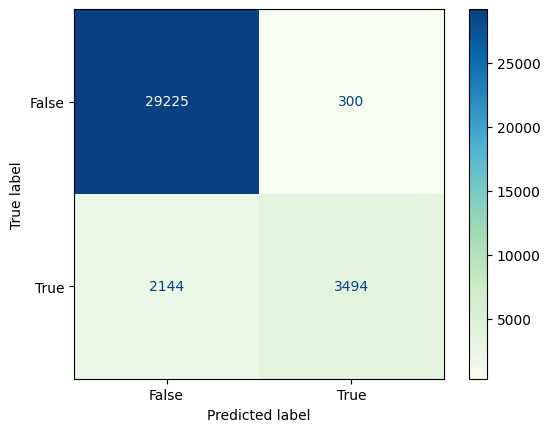

In [60]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_lsvc, 
                                        im_kw={'cmap':'GnBu'})
plt.show()

### Model 3

### Model 4

### Model 5

### Model 6